In [50]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

import keras
# import keras_retinanet
from object_detector_retinanet.keras_retinanet import models
from object_detector_retinanet.keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from object_detector_retinanet.keras_retinanet.utils.visualization import draw_box, draw_caption
from object_detector_retinanet.keras_retinanet.utils.colors import label_color

# import for EM Merger and viz
from object_detector_retinanet.keras_retinanet.utils import EmMerger
from object_detector_retinanet.utils import create_folder, root_dir


# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
from tqdm import tqdm_notebook

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)
keras.backend.tensorflow_backend.set_session(get_session())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


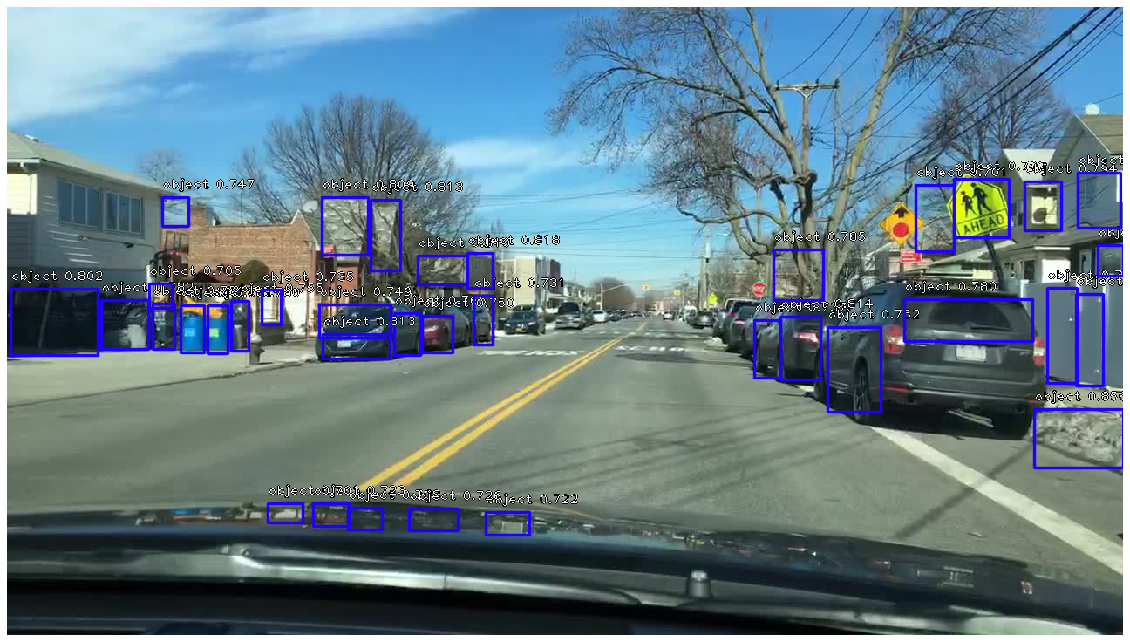

In [53]:
model_path = '/root/Documents/SKU110K/iou_resnet50_csv_06.h5'
model = models.load_model(model_path, backbone_name='resnet50', convert = 1, nms=False)

labels_to_names = {0: 'object'}
image_path = "samples/dc15a645-a4751ede.jpg"
image = read_image_bgr(image_path)

threshold = 0.05
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
image = preprocess_image(image)
image, scale = resize_image(image)
boxes, hard_scores, labels, soft_scores = model.predict_on_batch(np.expand_dims(image, axis=0))
hard_score_rate=.0
max_detections = 9999

soft_scores = np.squeeze(soft_scores, axis=-1)
soft_scores = hard_score_rate * hard_scores + (1 - hard_score_rate) * soft_scores
boxes /= scale

indices = np.where(hard_scores[0, :] > threshold)[0]

scores = soft_scores[0][indices]
hard_scores = hard_scores[0][indices]

scores_sort = np.argsort(-scores)[:max_detections]

image_boxes = boxes[0, indices[scores_sort], :]
image_scores = scores[scores_sort]
image_hard_scores = hard_scores[scores_sort]
image_labels = labels[0, indices[scores_sort]]
image_detections = np.concatenate(
    [image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_labels, axis=1)], axis=1)
results = np.concatenate(
    [image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_hard_scores, axis=1),
     np.expand_dims(image_labels, axis=1)], axis=1)
filtered_data = EmMerger.merge_detections(image_path, results)
filtered_boxes = []
filtered_scores = []
filtered_labels = []

csv_data_lst = []
csv_data_lst.append(['image_id', 'x1', 'y1', 'x2', 'y2', 'confidence', 'hard_score'])

for ind, detection in filtered_data.iterrows():
    box = np.asarray([detection['x1'], detection['y1'], detection['x2'], detection['y2']])
    filtered_boxes.append(box)
    filtered_scores.append(detection['confidence'])
    filtered_labels.append('{0:.2f}'.format(detection['hard_score']))
    row = [image_path, detection['x1'], detection['y1'], detection['x2'], detection['y2'],
           detection['confidence'], detection['hard_score']]
    csv_data_lst.append(row)
    
for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
    # scores are sorted so we can break
    if score < threshold:
        break
        
    color = [31, 0, 255]#label_color(label) ## BUG HERE LABELS ARE FLOATS SO COLOR IS HARDCODED 
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[0], score)
    draw_caption(draw, b, caption)

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(draw)
plt.show()